In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.interpolate import interp1d
from utils import *

In [2]:
SITE_NSRDB_IDX = 131123 # closest NSRDB site to Fort Ross (used KD tree from demo)
SITE_NOAA_ID = 9416024
SITE_TIMEZONE = 'America/Los_Angeles'

ghi_year = get_nsrdb_data('2016', 'ghi', SITE_NSRDB_IDX, SITE_TIMEZONE)

hot_rocks_df = get_hot_rocks_data()


Found cached/site-131123-data-2016.pkl, loading...


In [3]:
MONTH_FILTER = '2016-07'
water_temp_month = hot_rocks_df.loc[MONTH_FILTER]
ghi_month = ghi_year[MONTH_FILTER]

water_temp_high = water_temp_month[water_temp_month['elev'] == 'high']['temp']
water_temp_low = water_temp_month[water_temp_month['elev'] == 'low']['temp']

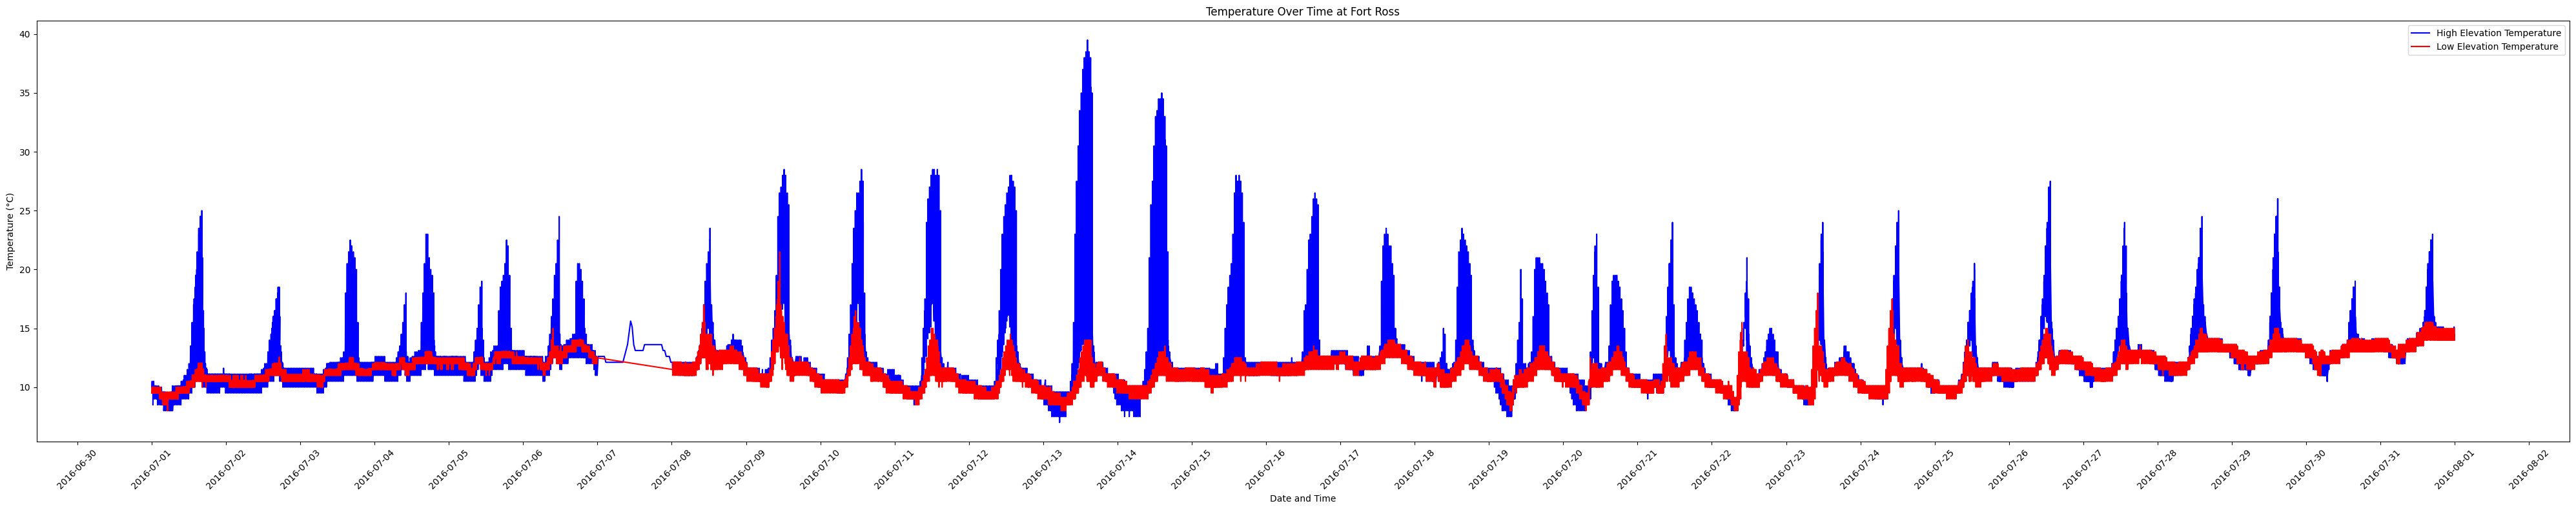

In [8]:
# Plotting the temperatures over time for both high and low elevations
plt.figure(figsize=(40, 8))
plt.plot(water_temp_high.index, water_temp_high, label='High Elevation Temperature', color='blue')
plt.plot(water_temp_low.index, water_temp_low, label='Low Elevation Temperature', color='red')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz=SITE_TIMEZONE))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))

plt.title('Temperature Over Time at Fort Ross')
plt.xlabel('Date and Time')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
start_of_month = pd.to_datetime(MONTH_FILTER)
end_of_month = start_of_month + pd.offsets.MonthEnd()
begin_date = (start_of_month - pd.Timedelta(days=1)).strftime('%Y%m%d')
end_date = (end_of_month + pd.Timedelta(days=1)).strftime('%Y%m%d')

# Define the API parameters
params = {
    'product': 'predictions',
    'application': 'NOS.COOPS.TAC.WL',
    'begin_date': begin_date, # extends 1d before and after for interpolation purposes
    'end_date': end_date,
    'datum': 'MLLW', # is this reasonable? https://tidesandcurrents.noaa.gov/datum_options.html
    'station': SITE_NOAA_ID,
    'time_zone': 'lst_ldt',
    'units': 'english',
    'interval': 'hilo',
    'format': 'json'
}

url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter'
tide_api_response = requests.get(url, params=params)

if tide_api_response.status_code == 200:
    tide_predictions_df = pd.DataFrame(tide_api_response.json()['predictions'])
    tide_index = pd.DatetimeIndex(tide_predictions_df['t']).tz_localize(SITE_TIMEZONE)
    tide_series = pd.Series(data=tide_predictions_df['v'].values, index=tide_index, dtype=float)
else:
    print('Failed to retrieve data:', tide_api_response.status_code)

# Convert timestamps to a numeric format for interpolation
tide_timestamps_numeric = mdates.date2num(tide_series.index)
interpolator = interp1d(tide_timestamps_numeric, tide_series, kind='cubic', fill_value='extrapolate')

tide_high_res_numeric = interpolator(mdates.date2num(ghi_month.index))
tide_high_res = pd.Series(data=tide_high_res_numeric, index=ghi_month.index)

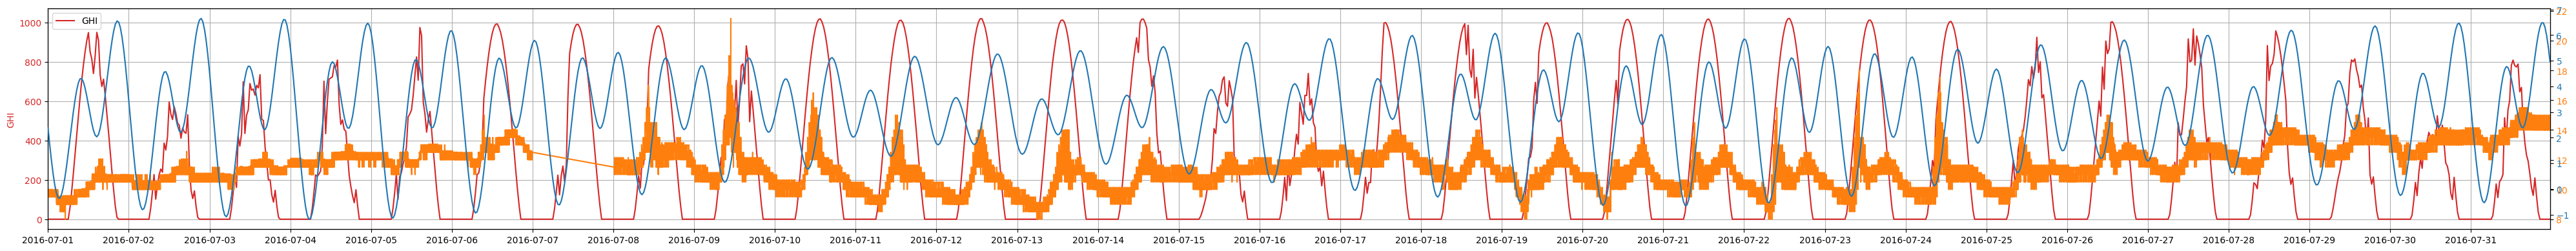

In [14]:
fig, ax1 = plt.subplots(figsize=(40, 4))

# Plot GHI data
ax1.plot(ghi_month.index, ghi_month, label='GHI', color='tab:red', zorder=3)
ax1.xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
plt.xlim(ghi_month.index[0], ghi_month.index[-1])
ax1.set_ylabel('GHI', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.plot(water_temp_low.index, water_temp_low['temp'], label='Low Tide Water Temp', color='tab:orange', linestyle='-', zorder=4)
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax3 = ax1.twinx()
ax3.plot(tide_high_res.index, tide_high_res, label='Tide', color='tab:blue', linestyle='-', zorder=4)
ax3.tick_params(axis='y', labelcolor='tab:blue')

ax1.grid(True)
ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


In [15]:
min_val, max_val = tide_high_res.min(), tide_high_res.max()
tide_values_normalized = (tide_high_res - min_val) / (max_val - min_val)

tide_values_inverted = 1 - tide_values_normalized

assert tide_values_inverted.shape == ghi_month.shape
tide_scaled_ghi = tide_values_inverted * ghi_month

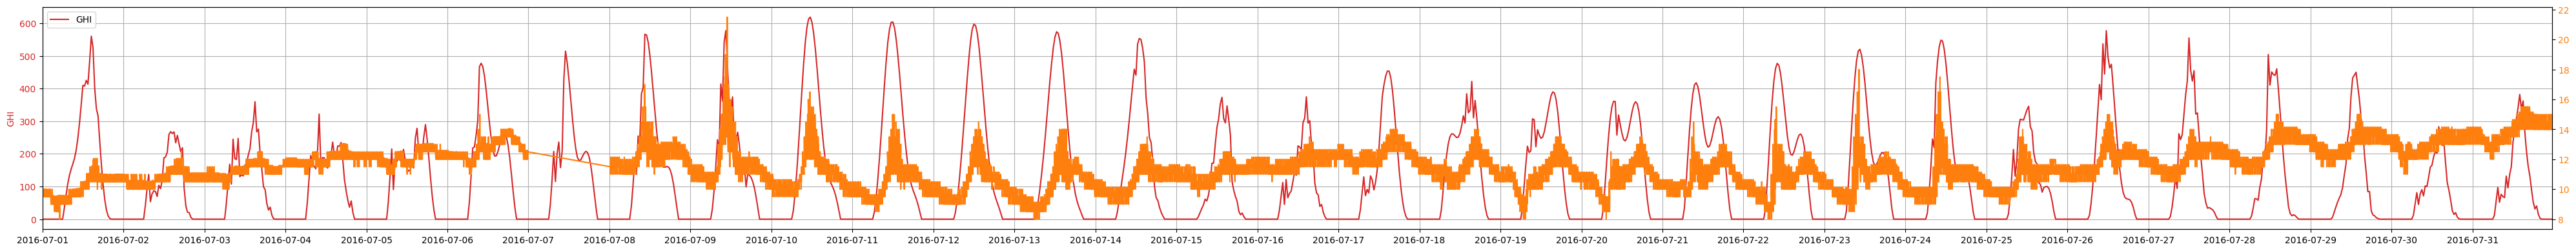

In [16]:
fig, ax1 = plt.subplots(figsize=(40, 4))

# Plot tide-scaled GHI data
ax1.plot(ghi_month.index, tide_scaled_ghi, label='GHI', color='tab:red', zorder=2)
ax1.xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
plt.xlim(ghi_month.index[0], ghi_month.index[-1])
ax1.set_ylabel('GHI', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.plot(water_temp_low.index, water_temp_low['temp'], label='Low Tide Water Temp', color='tab:orange', linestyle='-', zorder=1)
ax2.tick_params(axis='y', labelcolor='tab:orange')


ax1.grid(True)
ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


## Review Paper Contribution:
- Description of the approach
- link to code
- other figures helpful for describing the method

### Scatter Plot

X-axis: maximum heat predicted by model (daily)

Y-axis: maximum recorded temp from hot rocks (daily)

If we want to get more sophisticated, daily upper quartile average.

might as well try daily mean too


get relationship bt variables with regression analysis

only use the high loggers for now (blue?)